# Reference region and input function tail (RRIFT) method

<img src="images/NotebookFactory.png">

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Table of Contents

1. [Introduction](#introduction)

2. [Abstract](#abstract)

3. [Imports](#imports)

4. [Figures](#figures)

    1. [Figure 1](#figure-1)
    
        1. [Reference Tissue](#reference-tissue)
        
        2. [Tissue of Interest](#tissue-of-interest)
        
        3. [Input Function](#input-function)
        
        4. [RRIFT Fit](#rrift-fit)
        
    2. [Figure 2](#figure-2)
        
        1. [$K_{trans}$](#fig-2-1)
        
        2. [$V_{e}$](#fig-2-2)
        
        3. [$V_{p}$](#fig-2-3)
        
    3. [Figure 3](#figure-3)
    
        1. [$\widehat{k_{ep,RR}}$](#fig-3-1)
        
        2. [$K^{trans}_{RR}$](#fig-3-2)
    
        3. [$K_{e, RR}$](#fig-3-3)

# Introduction <a name="introduction"></a>

This is a jupyter notebook that introduces interactive plots created in plotly from some of figures in the paper [Pharmacokinetic modeling of dynamic contrast‐enhanced MRI using a reference region and input function tail](https://onlinelibrary.wiley.com/doi/abs/10.1002/mrm.27913). 

Link to the paper's GitHub repository: https://github.com/MPUmri/RRIFT

GitHub link to this notebook: https://github.com/Notebook-Factory/RRFIT_notebooks


# Abstract <a name="abstract"></a>

###  Purpose
Quantitative analysis of dynamic contrast‐enhanced MRI (DCE‐MRI) requires an arterial input function (AIF) which is difficult to measure. We propose the reference region and input function tail (RRIFT) approach which uses a reference tissue and the washout portion of the AIF.

### Methods
RRIFT was evaluated in simulations with 100 parameter combinations at various temporal resolutions (5‐30 s) and noise levels (σ = 0.01‐0.05 mM). RRIFT was compared against the extended Tofts model (ETM) in 8 studies from patients with glioblastoma multiforme. Two versions of RRIFT were evaluated: one using measured patient‐specific AIF tails, and another assuming a literature‐based AIF tail.

### Results
RRIFT estimated the transfer constant $K^{trans}$ and interstitial volume $V_{e}$ with median errors within 20% across all simulations. RRIFT was more accurate and precise than the ETM at temporal resolutions slower than 10 s. The percentage error of $K^{trans}$ had a median and interquartile range of −9 ± 45% with the ETM and −2 ± 17% with RRIFT at a temporal resolution of 30 s under noiseless conditions. RRIFT was in excellent agreement with the ETM in vivo, with concordance correlation coefficients (CCC) of 0.95 for $K^{trans}$, 0.96 for $V_{e}$, and 0.73 for the plasma volume $V_{p}$ using a measured AIF tail. With the literature‐based AIF tail, the CCC was 0.89 for $K^{trans}$, 0.93 for $V_{e}$ and 0.78 for $V_{p}$.

### Conclusions
Quantitative DCE‐MRI analysis using the input function tail and a reference tissue yields absolute kinetic parameters with the RRIFT method. This approach was viable in simulation and in vivo for temporal resolutions as low as 30 s.

## Imports <a name="imports"></a>

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd
from itertools import cycle
import itertools
from pandas.core.common import flatten
from plotly.subplots import make_subplots

# Figures <a name="figures"></a>

## Figure 1 <a name="figure-1"></a>


In [ ]:
%% Initialize
addpath('RRIFT/mfiles')
clearvars

rng(12345)
load('RRIFT/data/simMap.mat');
sigmaC = 0.03; % StdDev of noise (in units of mM)
TRes = 5; % Temporal resolution (in seconds)

% Properties for the simulated reference tissue
ktRR = 0.07; % Ktrans of ref.tissue, in units of 1/min
kepRR = 0.5; % kep of ref.tissue, in units of 1/min
veRR = ktRR/kepRR;
Crr = ToftsKety(Cp,[ktRR,kepRR],t);
%% Downsample and Add noise
Ct = downsample(simCt, TRes./initTRes);
Cp = downsample(Cp, TRes./initTRes);
Crr = downsample(Crr, TRes./initTRes);
t = downsample(t, TRes./initTRes);

[sT sX sY] = size(Ct);
Ct = reshape(Ct,[sT sX*sY]);
Ct = Ct + sigmaC * randn(size(Ct));
Cp = Cp + sigmaC * randn(size(Cp)) / (1-0.35);
Crr = Crr + 0.1 * sigmaC * randn(size(Crr));
%% Pick four voxels and fit them
% Chosen voxels (tried to avoid overlap of curves in figure)
idx = [5, 28, 53, 98];

% Fit the chosen voxels with CERRM
[pkCE, ~, estKepRR] = CERRM(Ct(:,idx),Crr,t);

% Use RRIFT, with AIF tail starting at 3 minutes into acquisition
fTail = find(t>3, 1);
[estKtRR, num, denum] = RRIFT(Cp(fTail:end), Crr(fTail:end), t(fTail:end), estKepRR);

* (A) Reference Tissue <a name="reference-tissue"></a>

In [ ]:
%get Crr --from MATLAB
%get Ct --from MATLAB
%get Cp --from MATLAB
%get t --from MATLAB
%get idx --from MATLAB
%get estKepRR --from MATLAB
%get pkCE --from MATLAB
%get denum --from MATLAB
%get num --from MATLAB


# ======================================= First subplot ===================================================================================

sub1 = go.Figure()

# sub1.add_trace(go.Scatter(x=t,y=Crr,mode='lines',line_color='#41B3A8')

sub1.add_trace(go.Scatter(x=t, y=Crr,
                    mode='lines', line_color='#41B3A8'))

sub1.update_layout(title='(A) Reference Tissue',
                   xaxis_title='Time [min]',
                   yaxis_title=r'Concentration [mM]',
                   plot_bgcolor="#fff",
                   xaxis=dict(showline=True,
                              range=[0, 10],
                              tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                   yaxis=dict(showline=True, 
                              range=[-0.01, 0.25], #the range from zero cuts out some values off
                              tickvals=[0, 0.05, 0.10, 0.15, 0.20, 0.25]),
                   
                 )

sub1.add_annotation(text=r'$K_{RR}^{trans}\space0.007\min{}^{-1}\\K_{ep, RR}\space0.50 \min{}^{-1}$',
                  xref="paper", yref="paper",
                  x=0.8, y=0.1, showarrow=False, font = dict(size = 26))
               
sub1.show()

* (B) Tissue of Interest <a name="tissue-of-interest"></a>

In [ ]:
%get Ct --from MATLAB
%get t --from MATLAB
%get idx --from MATLAB
%get estKepRR --from MATLAB
%get pkCE --from MATLAB


# Matlab's indexing starts at 1, whereas Python's starts from 0, so we need to
# lower all the indexes in idx by one to match the approprate data from the array

for i in range(idx.size):
    idx[i] = idx[i]-1

    
fig = go.Figure()

palette_lines = cycle(px.colors.qualitative.Plotly)
palette_labels = cycle(px.colors.qualitative.Plotly)
line_colours = cycle(['#292348','#585E9A','#88A8D5','#83C9C4'])
pkCE_index = cycle([4, 9, 14, 19])

pkCE_reshaped = np.ravel(pkCE)


for el in idx:
    reshaped_Ct = np.reshape(Ct[:,el], 120)
    final_Ct = np.squeeze(np.asarray(reshaped_Ct))
    trace_label = round(pkCE_reshaped[next(pkCE_index)], 3)
    fig.add_trace(go.Scatter(name=str(trace_label),
                             x=t, 
                             y=final_Ct, 
                             mode='lines',
                             line_color=next(line_colours)))

fig.update_layout(title='(B) Tissue of Interest',
                   xaxis=dict(title='Time [min]',
                              showline=True,
                              range=[0, 10],
                              tickvals=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                   yaxis=dict(title='Concentration [mM]',
                              showline=True,
                              range=[-0.1, 1.5],
                              tickvals=[0, 0.5, 1, 1.5]),
                   plot_bgcolor="#fff",
)

fig.add_annotation(text=r'$Estimate \space k_{ep, RR} \space (min^{-1})$',
                  xref="paper", yref="paper",
                  x=0.8, y=0.8, showarrow=False, font = dict(size = 26))


fig.show()

* (C) Input Function <a name="input-function"></a>

In [ ]:
%get t --from MATLAB
%get Cp --from MATLAB

fig = go.Figure()

fig.add_trace(go.Scatter(x=t, 
                         y=Cp, 
                         mode='lines',
                         line_color='red'))

fig.update_layout(title='(C) Input Function',
                   xaxis_title='Time [min]',
                   yaxis_title='Concentration [mM]',
                   xaxis_range=[0,10],
                   yaxis_range=[-0.1,11],
                   plot_bgcolor="#fff",
)

#Adding a shape region
fig.add_vrect(
    x0=3, x1=10,
    fillcolor="LightGray", opacity=0.5,
    layer="below", line_width=0,
    annotation=dict(text="Input Function Tail",
                  xref="x2 domain", yref="y2 domain",
                  xanchor="right", yanchor="top", 
                  xshift=-140, yshift=-100,
                  showarrow=False, font=dict(size=20, color='black'))
)

# T_{tail}
# An arrow for T_{tail} that points to the right side of the highlighted region
fig.add_annotation(
    x=10,  # arrows' head
    y=5,  # arrows' head
    ax=3, # arrows' tail
    ay=5,  # arrows' tail
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text='',  # if you want only the arrow
    showarrow=True,
    arrowhead=3,
    arrowsize=2,
    arrowwidth=2,
    arrowcolor='black'
)

# An arrow for T_{tail} that points to the left side of the highlighted region
fig.add_annotation(
    x=3,  # arrows' head
    y=5,  # arrows' head
    ax=10, # arrows' tail
    ay=5,  # arrows' tail
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text='',  # if you want only the arrow
    showarrow=True,
    arrowhead=3,
    arrowsize=2,
    arrowwidth=2,
    arrowcolor='black'
)

# Text annotation for T_{tail} below the arrows
fig.add_annotation(  
    x=6.5,
    y=4.6,
    text=r'$T_{tail}$',
    xanchor="center", yanchor="top", 
    showarrow=False, font=dict(size=20, color='black'))


# T_{start}
# An arrow for T_{start}
fig.add_annotation(
    x=3,  # arrows' head
    y=0,  # arrows' head
    ax=3, # arrows' tail
    ay=2,  # arrows' tail
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text=r'$T_{start}$',
    font=dict(size=16, color='black'),
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor='black'
)

# T_{end}
# An arrow for T_{end}
fig.add_annotation(
    x=10,  # arrows' head
    y=0,  # arrows' head
    ax=10, # arrows' tail
    ay=2,  # arrows' tail
    xref='x',
    yref='y',
    axref='x',
    ayref='y',
    text=r'$T_{end}$',
    font=dict(size=16, color='black'),
    showarrow=True,
    arrowhead=3,
    arrowsize=1,
    arrowwidth=2,
    arrowcolor='black'
)


fig.update_xaxes(tick0=0, dtick=1)
fig.show()

* (D) RRIFT Fit <a name="rrift-fit"></a>

In [ ]:
%get denum --from MATLAB
%get num --from MATLAB

line_fit = sm.OLS(num ,sm.add_constant(denum)).fit().fittedvalues

fig=go.Figure()
fig.add_trace(go.Scatter(name="Markers",
                         x=denum, 
                         y=num, 
                         mode='markers',
                         marker_symbol="circle-open", 
                         marker_size=14, 
                         marker_color='red'))
fig.add_trace(go.Scatter(name="Linear Fit",
                         x=denum, 
                         y=line_fit, 
                         mode='lines',
                         line_color="black"))

fig.add_annotation(text=r'$Slope | K_{RR}^{trans}: 0.071\space min^{-1}\\R^{2}:0.9996$',
                  xref="paper", yref="paper",
                  x=0.9, y=0.1, showarrow=False, font = dict(size = 26))

fig.update_layout(title='(D) RRIFT Fit',
                   xaxis_title='Denominator [mM * min]',
                   yaxis_title='Numerator [mM]',
                   xaxis=dict(showline=True,
                              range=[-0.1,7],
                              tickvals=[0, 1, 2, 3, 4, 5, 6, 7]),
                   yaxis=dict(showline=True,
                              range=[-0.015,0.5],
                              tickvals=[0, 0.1, 0.2, 0.3, 0.4, 0.5]),
                   plot_bgcolor="#fff",
)

fig.show()


## Figure 2 <a name="figure-2"></a>

In [ ]:
%% This code contains the variables for both figure 2 and 3

addpath('RRIFT/mfiles')
clearvars

load('RRIFT/data/simMap.mat');
load('RRIFT/data/simResults.mat');
%%
[nVox nP nRep nRes nSig] = size(params.CERRM);

pkCE = reshape(params.CERRM,[nVox 5 nRep*nRes*nSig]);
pkET = reshape(params.ETM,[nVox 3 nRep*nRes*nSig]);
pkCE = permute(pkCE,[1 3 2]);
pkET = permute(pkET,[1 3 2]);
%%
rrKt = repmat(estKtRR(:),[1 nVox])';
rrKep = repmat(estKepRRS(:),[1 nVox])';
rrVe = rrKt./rrKep;
%%
errKtCE = PercentError(pkCE(:,:,1).*rrKt,trueKt(:));
errVeCE = PercentError(pkCE(:,:,2).*rrVe,trueVe(:));
errVpCE = PercentError(pkCE(:,:,4).*rrKt,trueVp(:));

errKtET = PercentError(pkET(:,:,1),trueKt(:));
errVeET = PercentError(pkET(:,:,1)./pkET(:,:,2),trueVe(:));
errVpET = PercentError(pkET(:,:,3),trueVp(:));
%%
errKtCE = reshape(errKtCE,[nVox*nRep nRes nSig]);
errVeCE = reshape(errVeCE,[nVox*nRep nRes nSig]);
errVpCE = reshape(errVpCE,[nVox*nRep nRes nSig]);

errKtET = reshape(errKtET,[nVox*nRep nRes nSig]);
errVeET = reshape(errVeET,[nVox*nRep nRes nSig]);
errVpET = reshape(errVpET,[nVox*nRep nRes nSig]);
%%
errKepRR = PercentError(reshape(estKepRRS,[nRep nRes*nSig]),kepRR);
errKtRR = PercentError(reshape(estKtRR,[nRep nRes*nSig]),ktRR);
errVeRR = PercentError(reshape(estKtRR./estKepRRS,[nRep nRes*nSig]),veRR);

errKepRRD = PercentError(reshape(estKepRRS,[nRep nRes*nSig]),kepRR);
errKtRRD = PercentError(reshape(estKtRRD,[nRep nRes*nSig]),ktRR);
errVeRRD = PercentError(reshape(estKtRRD./estKepRRS,[nRep nRes*nSig]),veRR);

errKepRR = reshape(errKepRR,[nRep nRes nSig]);
errKtRR = reshape(errKtRR,[nRep nRes nSig]);
errVeRR = reshape(errVeRR,[nRep nRes nSig]);

errKepRRD = reshape(errKepRRD,[nRep nRes nSig]);
errKtRRD = reshape(errKtRRD,[nRep nRes nSig]);
errVeRRD = reshape(errVeRRD,[nRep nRes nSig]);
%%
errKtCE = shiftdim(errKtCE,1);
errVeCE = shiftdim(errVeCE,1);
errVpCE = shiftdim(errVpCE,1);

errKtET = shiftdim(errKtET,1);
errVeET = shiftdim(errVeET,1);
errVpET = shiftdim(errVpET,1);

errKepRR = shiftdim(errKepRR,1);
errKtRR = shiftdim(errKtRR,1);
errVeRR = shiftdim(errVeRR,1);

errKepRRD = shiftdim(errKepRRD,1);
errKtRRD = shiftdim(errKtRRD,1);
errVeRRD = shiftdim(errVeRRD,1);

%% Median/IQR RR
cSize = 10;
iList = 1:4;

%% FIRST SUBFIGURE
curErr = errKepRR;
errQt = quantile(curErr,[.25 .75],3);
errMd = median(curErr,3);

%% SECOND SUBFIGURE
curErr1 = errKtRR;
errQt1 = quantile(curErr1,[.25 .75],3);
errMd1 = median(curErr1,3);

%% THIRD SUBFIGURE
curErr2 = errVeRR;
errQt2 = quantile(curErr2,[.25 .75],3);
errMd2 = median(curErr2,3);

curErr3 = errKtCE;
errQt3 = quantile(curErr3,[.25 .75],3);
errMd3 = median(curErr3,3);

curErr4 = errVeCE;
errQt4 = quantile(curErr4,[.25 .75],3);
errMd4 = median(curErr4,3);

curErr5 = errVpCE;
errQt5 = quantile(curErr5,[.25 .75],3);
errMd5 = median(curErr5,3);

In [ ]:
%get listSigmaC --from MATLAB
%get curErr3 --from MATLAB
%get errQt3 --from MATLAB
%get errMd3 --from MATLAB
%get curErr4 --from MATLAB
%get errQt4 --from MATLAB
%get errMd4 --from MATLAB
%get curErr5 --from MATLAB
%get errQt5 --from MATLAB
%get errMd5 --from MATLAB


fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$K^{trans}$', r'$V_{e}$', r'$V_{p}$'))

legend_values=cycle(['5','10','15','30'])

# First subplot 
line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])

for i in range(0,4):
    finalErrMd3=np.squeeze(np.asarray((np.reshape(errMd3[i,:], 6))))
    # take another look here - is it errorQt[i,:,1] because MATLAB indexing starts from 1,
    # or is it just like in MATLAB?
    finalErrorDiff3=np.squeeze(np.asarray((np.reshape(abs(errQt3[i,:,0]-errMd3[i,:]), 6))))
    finalErrorDiffMinus3=np.squeeze(np.asarray((np.reshape(abs(errQt3[i,:,1]-errMd3[i,:]), 6))))
    fig.append_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd3,
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff3,
            arrayminus=finalErrorDiffMinus3,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4
    ),row=1, col=1)
    


# Second subplot

line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])

for i in range(0,4):
    finalErrMd4=np.squeeze(np.asarray((np.reshape(errMd4[i,:], 6))))
    
    finalErrorDiff4=np.squeeze(np.asarray((np.reshape(abs(errQt4[i,:,0]-errMd4[i,:]), 6))))
    finalErrorDiffMinus4=np.squeeze(np.asarray((np.reshape(abs(errQt4[i,:,1]-errMd4[i,:]), 6))))
    fig.append_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd4,
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff4,
            arrayminus=finalErrorDiffMinus4,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4       
    ),row=1, col=2)


# Third subplot
    


line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])

for i in range(0,4):
    finalErrMd5=np.squeeze(np.asarray((np.reshape(errMd5[i,:], 6))))
    finalErrorDiff5=np.squeeze(np.asarray((np.reshape(abs(errQt5[i,:,0]-errMd5[i,:]), 6))))
    finalErrorDiffMinus5=np.squeeze(np.asarray((np.reshape(abs(errQt5[i,:,1]-errMd5[i,:]), 6))))
    fig.add_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd5,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff5,
            arrayminus=finalErrorDiffMinus5,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        showlegend=True,
        line_color=next(line_colours),
        line_width=4
    ),row=1, col=3)



fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_yaxes(range=[-50,50], tickvals=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], row=1, col=1)
fig.update_yaxes(range=[-50,50], tickvals=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], row=1, col=2)
fig.update_yaxes(range=[-50,50], tickvals=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], row=1, col=3)

fig.update_layout(yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             ), 
                  plot_bgcolor='#ffffff'
                  #legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30) -- change legend position
)


# names = set()
# fig.for_each_trace(
#     lambda trace:
#         trace.update(showlegend=False)
#         if (trace.name in names) else names.add(trace.name))


fig.show()


### Subfigures with sliders

* $K^{trans}$: <a name="fig-2-1"></a>

In [ ]:
%get listSigmaC --from MATLAB
%get curErr3 --from MATLAB
%get errQt3 --from MATLAB
%get errMd3 --from MATLAB

# First subplot
line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])
legend_values=cycle(['5','10','15','30'])

fig = go.Figure()
for i in range(0,4):
    finalErrMd3=np.squeeze(np.asarray((np.reshape(errMd3[i,:], 6))))
    finalErrorDiff3=np.squeeze(np.asarray((np.reshape(abs(errQt3[i,:,0]-errMd3[i,:]), 6))))
    finalErrorDiffMinus3=np.squeeze(np.asarray((np.reshape(abs(errQt3[i,:,1]-errMd3[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd3,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff3,
            arrayminus=finalErrorDiffMinus3,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False, name=next(legend_values)
    ))
    

# Default value on the slider    
fig.data[0].visible = True
legend_values = [5, 10, 15, 30]

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],  # layout attribute
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]


fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$V_{e}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-35,5],
                             tickvals=[-35,-30,-25,-20,-15,-10,-5,0,5],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders)



fig.show()    


* $V_{e}$: <a name="fig-2-2"></a>

In [ ]:
# Second subplot

line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])
legend_values=cycle(['5','10','15','30'])
fig = go.Figure()

for i in range(0,4):
    finalErrMd4=np.squeeze(np.asarray((np.reshape(errMd4[i,:], 6))))
    
    finalErrorDiff4=np.squeeze(np.asarray((np.reshape(abs(errQt4[i,:,0]-errMd4[i,:]), 6))))
    finalErrorDiffMinus4=np.squeeze(np.asarray((np.reshape(abs(errQt4[i,:,1]-errMd4[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd4,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff4,
            arrayminus=finalErrorDiffMinus4,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False, name=next(legend_values)       
    ))
    
    
# Default value on the slider    
fig.data[0].visible = True

legend_values = [5, 10, 15, 30]

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
#               {"title": "Current value selected on slider: " + str(legend_values[i])}
             ],  # layout attribute
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]


fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$V_{e}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-10,10],
                             tickvals=[-10,-5,0,5, 10],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders
)


fig.show()  

* $V_{p}$: <a name="fig-2-3"></a>

In [ ]:
# Third subplot

fig = go.Figure()
line_colours = cycle(['#253494','#2C7fB8','#41B6C4','#A1DAB4'])
legend_values=cycle(['5','10','15','30'])
for i in range(0,4):
    finalErrMd5=np.squeeze(np.asarray((np.reshape(errMd5[i,:], 6))))
    finalErrorDiff5=np.squeeze(np.asarray((np.reshape(abs(errQt5[i,:,0]-errMd5[i,:]), 6))))
    finalErrorDiffMinus5=np.squeeze(np.asarray((np.reshape(abs(errQt5[i,:,1]-errMd5[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd5,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff5,
            arrayminus=finalErrorDiffMinus5,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False, name=next(legend_values)) 
    )
    
    
# Default value on the slider    
fig.data[0].visible = True

legend_values = [5, 10, 15, 30]

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]


fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$V_{p}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-170,50],
                             tickvals=[-160,-130,-100,-70,-40,-10,20,50],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders
)


fig.show()  

## Figure 3 <a name="figure-3"></a>

In [ ]:
%get listSigmaC --from MATLAB
%get curErr --from MATLAB
%get errQt --from MATLAB
%get errMd --from MATLAB
%get curErr1 --from MATLAB
%get errQt1 --from MATLAB
%get errMd1 --from MATLAB
%get curErr2 --from MATLAB
%get errQt2 --from MATLAB
%get errMd2 --from MATLAB



fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$\widehat{k_{ep,RR}}$', r'$K^{trans}_{RR}$', r'$V_{e,RR}$'),
                    )

# First subplot 
line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])

legend_values = cycle([5, 10, 15, 30])


for i in range(0,4):
    finalErrMd=np.squeeze(np.asarray((np.reshape(errMd[i,:], 6))))
    finalErrorDiff=np.squeeze(np.asarray((np.reshape(abs(errQt[i,:,0]-errMd[i,:]), 6))))
    finalErrorDiffMinus=np.squeeze(np.asarray((np.reshape(abs(errQt[i,:,1]-errMd[i,:]), 6))))
    fig.add_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff,
            arrayminus=finalErrorDiffMinus,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4, showlegend=False
    ),row=1, col=1)
    



# Second subplot

line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])

for i in range(0,4):
    finalErrMd1=np.squeeze(np.asarray((np.reshape(errMd1[i,:], 6))))
    
    finalErrorDiff1=np.squeeze(np.asarray((np.reshape(abs(errQt1[i,:,0]-errMd1[i,:]), 6))))
    finalErrorDiffMinus1=np.squeeze(np.asarray((np.reshape(abs(errQt1[i,:,1]-errMd1[i,:]), 6))))
    fig.add_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd1,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff1,
            arrayminus=finalErrorDiffMinus1,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4, showlegend=False       
    ),row=1, col=2)




# Third subplot

legend_values=cycle(['5','10','15','30'])

    
line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])

for i in range(0,4):
    finalErrMd2=np.squeeze(np.asarray((np.reshape(errMd2[i,:], 6))))
    
    finalErrorDiff2=np.squeeze(np.asarray((np.reshape(abs(errQt2[i,:,0]-errMd2[i,:]), 6))))
    finalErrorDiffMinus2=np.squeeze(np.asarray((np.reshape(abs(errQt2[i,:,1]-errMd2[i,:]), 6))))
    fig.add_trace(go.Scatter(
        x=listSigmaC,
        y=finalErrMd2,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff2,
            arrayminus=finalErrorDiffMinus2,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4, showlegend=True      
    ),row=1, col=3)

# General

fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')

fig.update_yaxes(range=[-35,5], tickvals=[-35,-30,-25,-20,-15,-10,-5,0,5], row=1, col=1)
fig.update_yaxes(range=[-35,5], tickvals=[-35,-30,-25,-20,-15,-10,-5,0,5], row=1, col=2)
fig.update_yaxes(range=[-35,5], tickvals=[-35,-30,-25,-20,-15,-10,-5,0,5], row=1, col=3)

fig.update_layout(yaxis=dict(title=r'$Percent Error$',
                             showline=True), 
                  plot_bgcolor='#ffffff',
)

fig.show()


### Subfigures with sliders 

* $\widehat{k_{ep,RR}}$ <a name="fig-3-1"></a>

In [ ]:
%get listSigmaC --from MATLAB
%get curErr --from MATLAB
%get errQt --from MATLAB
%get errMd --from MATLAB

fig = go.Figure()

legend_values = [5, 10, 15, 30]

line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])

for i in range(0,4):
    finalErrMd=np.squeeze(np.asarray((np.reshape(errMd[i,:], 6))))
    finalErrorDiff=np.squeeze(np.asarray((np.reshape(abs(errQt[i,:,0]-errMd[i,:]), 6))))
    finalErrorDiffMinus=np.squeeze(np.asarray((np.reshape(abs(errQt[i,:,1]-errMd[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff,
            arrayminus=finalErrorDiffMinus,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False
    ))
    
# Default value on the slider    
fig.data[0].visible = True


# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]


fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$\widehat{k_{ep,RR}}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-35,5],
                             tickvals=[-35,-30,-25,-20,-15,-10,-5,0,5],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders
)


fig.show()

* $K^{trans}_{RR}$ <a name="fig-3-2"></a>

In [ ]:
%get listSigmaC --from MATLAB
%get curErr1 --from MATLAB
%get errQt1 --from MATLAB
%get errMd1 --from MATLAB

fig = go.Figure()

legend_values = [5, 10, 15, 30]

line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])
    
for i in range(0,4):
    finalErrMd1=np.squeeze(np.asarray((np.reshape(errMd1[i,:], 6))))
    
    finalErrorDiff1=np.squeeze(np.asarray((np.reshape(abs(errQt1[i,:,0]-errMd1[i,:]), 6))))
    finalErrorDiffMinus1=np.squeeze(np.asarray((np.reshape(abs(errQt1[i,:,1]-errMd1[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd1,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff1,
            arrayminus=finalErrorDiffMinus1,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False       
    ))



    
# Default value on the slider    
fig.data[0].visible = True


# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]

fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$K^{trans}_{RR}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-25,5],
                             tickvals=[-25,-20,-15,-10,-5,0,5],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders
)


fig.show()

* $V_{e,RR}$ <a name="fig-3-3"></a>

In [ ]:
%get curErr2 --from MATLAB
%get errQt2 --from MATLAB
%get errMd2 --from MATLAB

fig = go.Figure()

legend_values = [5, 10, 15, 30]

line_colours = cycle(['#006837','#31A354','#78C679','#C2E699'])

for i in range(0,4):
    finalErrMd2=np.squeeze(np.asarray((np.reshape(errMd2[i,:], 6))))
    
    finalErrorDiff2=np.squeeze(np.asarray((np.reshape(abs(errQt2[i,:,0]-errMd2[i,:]), 6))))
    finalErrorDiffMinus2=np.squeeze(np.asarray((np.reshape(abs(errQt2[i,:,1]-errMd2[i,:]), 6))))
    fig.add_trace(go.Scatter(
        visible=False,
        x=listSigmaC,
        y=finalErrMd2,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=finalErrorDiff2,
            arrayminus=finalErrorDiffMinus2,
            symmetric=False,
            visible=True,
            thickness=4),
        line_color=next(line_colours),
        line_width=4, showlegend=False      
    ))



    
# Default value on the slider    
fig.data[0].visible = True


# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
        value=legend_values[i],
        label=legend_values[i]        
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=4,
    currentvalue={"prefix": "Temporal resolution [seconds]: "},
    pad={"t": 70}, #upper padding 
    steps=steps
)]


fig.update_xaxes(title_text=r'$\sigma_{noise}[Mm]$')
fig.update_layout(title=dict(text=r'$V_{e,RR}$',
                             x=0.5,
                             xanchor='center'),
                  yaxis=dict(title=r'$Percent Error$',
                             showline=True,
                             range=[-10,5],
                             tickvals=[-10,-5,0,5],
                             ), 
                  plot_bgcolor='#ffffff',
                  legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30),
                  sliders=sliders
)


fig.show()

## Figure 4

In [ ]:
%% LOAD
addpath('RRIFT/mfiles')
clearvars

load('RRIFT/data/simMap.mat');
load('RRIFT/data/simResultsTRes15-varKtRR.mat');

estRRM = zeros(9,3,100,repF);
estRRIFT = estRRM;
estETM = permute(pkETM,[1 3 2 4]);
estETM(:,2,:,:) = estETM(:,1,:,:)./estETM(:,2,:,:);

errRRM = zeros(9,3,100*repF);
errRRIFT = errRRM;
errETM = errRRM;

estVeRR = estKtRR ./ estKepRRS;

for i=1:9
        estRRM(i,1,:,:) = pkCERRM(i,:,1,:) * 0.07;
        estRRM(i,2,:,:) = pkCERRM(i,:,2,:) * 0.14;
        estRRM(i,3,:,:) = pkCERRM(i,:,4,:) * 0.07;
        
        for k=1:repF
            estRRIFT(i,1,:,k) = pkCERRM(i,:,1,k) * estKtRR(i,k);
            estRRIFT(i,2,:,k) = pkCERRM(i,:,2,k) * estVeRR(i,k);
            estRRIFT(i,3,:,k) = pkCERRM(i,:,4,k) * estKtRR(i,k);
        end
        
        errRRM(i,1,:) = reshape(PercentError(squeeze(estRRM(i,1,:,:)),trueKt(:)),1,[]);
        errRRM(i,2,:) = reshape(PercentError(squeeze(estRRM(i,2,:,:)),trueVe(:)),1,[]);
        errRRM(i,3,:) = reshape(PercentError(squeeze(estRRM(i,3,:,:)),trueVp(:)),1,[]);
        
        errRRIFT(i,1,:) = reshape(PercentError(squeeze(estRRIFT(i,1,:,:)),trueKt(:)),1,[]);
        errRRIFT(i,2,:) = reshape(PercentError(squeeze(estRRIFT(i,2,:,:)),trueVe(:)),1,[]);
        errRRIFT(i,3,:) = reshape(PercentError(squeeze(estRRIFT(i,3,:,:)),trueVp(:)),1,[]);
        
        errETM(i,1,:) = reshape(PercentError(squeeze(estETM(i,1,:,:)),trueKt(:)),1,[]);
        errETM(i,2,:) = reshape(PercentError(squeeze(estETM(i,2,:,:)),trueVe(:)),1,[]);
        errETM(i,3,:) = reshape(PercentError(squeeze(estETM(i,3,:,:)),trueVp(:)),1,[]);
end
trueKtRR0=trueKtRR; % Save to tmp variable because next loading step will overwrite it
load('RRIFT/data/simResultsTRes15-varVeRR.mat');
estVeRR = estKtRR ./ estKepRRS;

for i=1:9
        estRRM(i,2,:,:) = pkCERRM(i,:,2,:) * 0.14;
        
        for k=1:repF
            estRRIFT(i,2,:,k) = pkCERRM(i,:,2,k) * estVeRR(i,k);
        end
        
        errRRM(i,2,:) = reshape(PercentError(squeeze(estRRM(i,2,:,:)),trueVe(:)),1,[]);
        errRRIFT(i,2,:) = reshape(PercentError(squeeze(estRRIFT(i,2,:,:)),trueVe(:)),1,[]);
        errETM(i,2,:) = reshape(PercentError(squeeze(estETM(i,2,:,:)),trueVe(:)),1,[]);
end
trueKtRR = trueKtRR0;
%% Error plots
% Err in Ktrans
cSize = 10;
yrange = [-100 100];
myColours = [0.895, 0.350, 0.280;...
             0.160, 0.140, 0.280;...
             0.750, 0.750, 0.750];

err1 = squeeze(errRRM(:,1,:));
err2 = squeeze(errRRIFT(:,1,:));
err3 = squeeze(errETM(:,1,:));

Ktrans_avg1 = nanmedian(err1,2);
Ktrans_avg2 = nanmedian(err2,2);
Ktrans_avg3 = nanmedian(err3,2);

Ktrans_ci1 = quantile(err1,[.25 .75],2);
Ktrans_ci2 = quantile(err2,[.25 .75],2);
Ktrans_ci3 = quantile(err3,[.25 .75],2);

% Err in Ve

err1 = squeeze(errRRM(:,2,:));
err2 = squeeze(errRRIFT(:,2,:));
err3 = squeeze(errETM(:,2,:));

Ve_avg1 = nanmedian(err1,2);
Ve_avg2 = nanmedian(err2,2);
Ve_avg3 = nanmedian(err3,2);

Ve_ci1 = quantile(err1,[.25 .75],2);
Ve_ci2 = quantile(err2,[.25 .75],2);
Ve_ci3 = quantile(err3,[.25 .75],2);

% Err in Vp
err1 = squeeze(errRRM(:,3,:));
err2 = squeeze(errRRIFT(:,3,:));
err3 = squeeze(errETM(:,3,:));

Vp_avg1 = nanmedian(err1,2);
Vp_avg2 = nanmedian(err2,2);
Vp_avg3 = nanmedian(err3,2);

Vp_ci1 = quantile(err1,[.25 .75],2);
Vp_ci2 = quantile(err2,[.25 .75],2);
Vp_ci3 = quantile(err3,[.25 .75],2);

In [ ]:
%get trueKtRR --from MATLAB
%get trueVeRR --from MATLAB

%get Ktrans_ci1 --from MATLAB
%get Ktrans_ci2 --from MATLAB
%get Ktrans_ci3 --from MATLAB
%get Ktrans_avg1 --from MATLAB
%get Ktrans_avg2 --from MATLAB
%get Ktrans_avg3 --from MATLAB

%get Ve_ci1 --from MATLAB
%get Ve_ci2 --from MATLAB
%get Ve_ci3 --from MATLAB
%get Ve_avg1 --from MATLAB
%get Ve_avg2 --from MATLAB
%get Ve_avg3 --from MATLAB


%get Vp_ci1 --from MATLAB
%get Vp_ci2 --from MATLAB
%get Vp_ci3 --from MATLAB
%get Vp_avg1 --from MATLAB
%get Vp_avg2 --from MATLAB
%get Vp_avg3 --from MATLAB


# The subplot titles are different in the paper and in the code (check which ones to use)
fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$K^{trans}$', r'$V_{e}$', r'$V_{p}$'))

legend_values=cycle(['ETM','RRIFT','RRM w/ fixed RR params'])
line_colours = cycle(['#bfbfbf', '#292447', '#e45947'])


# First subplot - Ktrans

Ktrans_ci = [Ktrans_ci3, Ktrans_ci2, Ktrans_ci1]
Ktrans_avg = [Ktrans_avg3, Ktrans_avg2, Ktrans_avg1]

for i in range(0,3):
    ci_values_negative = np.squeeze(np.asarray(np.reshape(Ktrans_ci[i][:,0], 9)))
    ci_values_positive = np.squeeze(np.asarray(np.reshape(Ktrans_ci[i][:,1], 9)))
    negative = Ktrans_avg[i]-ci_values_negative
    positive = ci_values_positive-Ktrans_avg[i]
    fig.append_trace(go.Scatter(
        x=trueKtRR,
        y=Ktrans_avg[i],
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=positive,
            arrayminus=negative,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4
    ),row=1, col=1)


# Second subplot - Ve

Ve_ci = [Ve_ci3, Ve_ci2, Ve_ci1]
Ve_avg = [Ve_avg3, Ve_avg2, Ve_avg1]

for i in range(0,3):
    ci_values_negative = np.squeeze(np.asarray(np.reshape(Ve_ci[i][:,0], 9)))
    ci_values_positive = np.squeeze(np.asarray(np.reshape(Ve_ci[i][:,1], 9)))
    negative = Ve_avg[i]-ci_values_negative
    positive = ci_values_positive-Ve_avg[i]
    fig.append_trace(go.Scatter(
        x=trueVeRR,
        y=Ve_avg[i],
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=positive,
            arrayminus=negative,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4
    ),row=1, col=2)


# Third subplot - Vp

Vp_ci = [Vp_ci3, Vp_ci2, Vp_ci1]
Vp_avg = [Vp_avg3, Vp_avg2, Vp_avg1]

for i in range(0,3):
    ci_values_negative = np.squeeze(np.asarray(np.reshape(Vp_ci[i][:,0], 9)))
    ci_values_positive = np.squeeze(np.asarray(np.reshape(Vp_ci[i][:,1], 9)))
    negative = Vp_avg[i]-ci_values_negative
    positive = ci_values_positive-Vp_avg[i]
    fig.append_trace(go.Scatter(
        x=trueKtRR,
        y=Vp_avg[i],
        showlegend=True,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=positive,
            arrayminus=negative,
            symmetric=False,
            visible=True,
            thickness=4),
        name=next(legend_values),
        legendgroup=i,
        line_color=next(line_colours),
        line_width=4
    ),row=1, col=3)
    
    
fig.update_xaxes(title_text=r'$\textrm{True }K^{trans}$', row=1, col=1)
fig.update_xaxes(title_text=r'$\textrm{True }V_{e, RR}$', row=1, col=2)
fig.update_xaxes(title_text=r'$\textrm{True }K^{trans}_{RR}$', row=1, col=3)

fig.update_yaxes(range=[-100,100], tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100], row=1, col=1)
fig.update_yaxes(range=[-100,100], tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100], row=1, col=2)
fig.update_yaxes(range=[-100,100], tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100], row=1, col=3)

    
fig.update_layout(yaxis=dict(title=r'$Percent Error$',showline=True), 
                  plot_bgcolor='#ffffff'
                  #legend=dict(yanchor='bottom', y=0.20, xanchor='right', x=0.30) -- change legend position
)

    
fig.show()


## Figure 7

In [115]:
%% Description
% Loads maps from RRIFT and Extended Tofts Model
% Displays maps for a single patient at 3 slices
% Also plots the AIF/Muscle curve and RRIFT fit

% Estimated runtime: 1 second

%%
clearvars
fclose('all')
addpath('./RRIFT/mfiles')
tic
inDir = './RRIFT/data/TCGA-GBM-Results/c02_postprocessed';
matFiles = dir([inDir '/*.mat']);

idx = 7; % Chosen Patient (choices are between 1:9)
curFile = matFiles(idx).name;

load(fullfile(inDir,curFile));



ans =

     0




In [114]:
%get t --from MATLAB
%get Cp --from MATLAB

%get Crr --from MATLAB

%get denum --from MATLAB
%get num --from MATLAB

%get t --from MATLAB
%get Cp --from MATLAB

%get Crr --from MATLAB

%get denum --from MATLAB
%get num --from MATLAB



fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$Blood Plasma$', r'$Muscle$', r'$RRIFT fit$'))





# First subplot




fig.append_trace(go.Scatter(
        x=t,
        y=Cp,
        showlegend=False,
        line_color='#e3988b',
    ),row=1, col=1)


# TODO: Make this text stay in one place when zooming in and out??

fig.add_vrect(
    x0=2.8, x1=6.1, fillcolor='#e6e6e6', layer='below', line_width=0,
    annotation=dict(text=r"$Tail$", xanchor="right", yanchor="top", showarrow=False, xshift=-60, yshift=-50, font=dict(size=17, color='black'))
)

# Prettier but doesn't stay in one place

# fig.add_vrect(
#     x0=2.8, x1=6.1, fillcolor='#e6e6e6', layer='below', line_width=0,
#     annotation=dict(text=r"$t_{start}$", xanchor="right", yanchor="top", showarrow=False, xshift=-125, yshift=-110, font=dict(size=17, color='black'))
# )

# fig.add_vrect(
#     x0=2.8, x1=6.1, fillcolor='#e6e6e6', layer='below', line_width=0,
#     annotation=dict(text=r"$t_{end}$", xref='x', axref='x', yref='y', ayref='y', xanchor="right", yanchor="top", showarrow=False, xshift=-5, yshift=-110, font=dict(size=17, color='black'))
# )



fig.add_annotation(
        x=2.8,
        y=4.65,
        ax=6.1,
        ay=4.65,
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text="",
        showarrow=True,
        align="right",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=3,
        arrowcolor="black",
         row=1, col=1
        )

fig.add_annotation(
        x=6.1,
        y=4.65,
        ax=2.8,
        ay=4.65,
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        text="",
        showarrow=True,
        align="right",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=3,
        arrowcolor="black",
         row=1, col=1
        )

fig.add_annotation(
        x=2.8,
        y=2.65,
        ax=2.8,
        ay=3.65,
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        yshift=-50,
        text=r'$t_{start}$',
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
        arrowhead=2,
        arrowsize=1,
        arrowwidth=3,
        arrowcolor="black",
         row=1, col=1
        )

fig.add_annotation(
        x=6.1,
        y=2.65,
        ax=6.1,
        ay=3.65,
        xref='x',
        yref='y',
        axref='x',
        ayref='y',
        yshift=-50,
        text=r'$t_{end}$',
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="black"
            ),
        align="right",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=3,
        arrowcolor="black",
         row=1, col=1
        )



# Second subplot 




fig.append_trace(go.Scatter(
        x=t,
        y=Crr,
        showlegend=False,
        line_color='#97d6d0',
    ),row=1, col=2)



# Third subplot

line_fit = sm.OLS(num ,sm.add_constant(denum)).fit().fittedvalues


fig.append_trace(go.Scatter(x=denum, 
                         y=num, 
                         mode='markers',
                         marker_symbol="circle-open", 
                         marker_size=14, 
                         marker_color='red', showlegend=False), row=1, col=3)
fig.append_trace(go.Scatter(x=denum, 
                         y=line_fit, 
                         mode='lines',
                         line_color="black", showlegend=False), row=1, col=3)







fig.update_yaxes(title_text=r'$Concentration [mM]$',
                 range=[0, 6], 
                 tickvals=[1, 2, 3, 4, 5, 6],
                 row=1, col=1)
fig.update_yaxes(title_text=r'$Concentration [mM]$',
                 range=[0, 0.30], 
                 tickvals=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                 row=1, col=2)
fig.update_yaxes(title_text=r'$Numerator$',
                 range=[0, 0.35], 
                 tickvals=[0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35],
                 row=1, col=3)



fig.update_xaxes(title_text=r'$Time [min]$',
                 range=[0, 7], 
                 tickvals=[0, 2, 4, 6],
                 row=1, col=1)
fig.update_xaxes(title_text=r'$Time [min]$',
                 range=[0, 6], 
                 tickvals=[0, 2, 4, 6],
                 row=1, col=2)
fig.update_xaxes(title_text=r'$Time [min]$',
                 range=[0, 6], 
                 tickvals=[0, 2, 4, 6],
                 row=1, col=3)








fig.show()

## Figure 8

In [ ]:
%% Description
% - Loads fitting results from c02_doRRIFT.m
% - Makes figures for analyzing results

%% Initialize
clearvars
fclose('all');
addpath('./RRIFT/mfiles')

%% Configuration

inDir = './RRIFT/data/TCGA-GBM-Results/c02_postprocessed'; % Input directory (output from c02_doRRIFT.m)

%% Main

matFiles = dir([inDir '/*.mat']);

% Initialize arrays (the variable names will be cleaned up later)
[
    arrKtETM, arrKepETM, arrVeETM, arrVpETM,... % Tumour parameters from ETM
    arrKtRRIFT, arrKepRRIFT, arrVeRRIFT, arrVpRRIFT,... % Tumour parameters from RRIFT-measuredTail
    arrKtRRIFTPop, arrVeRRIFTPop, arrVpRRIFTPop,... % Tumour parameters from RRIFT-assumedTail
    arrKtRRM, arrVeRRM, arrVpRRM,... % Tumour parameters from reference region model (i.e. relative parameters)
    crrList, cpList, tList... % Reference tissue & AIF curve for each patient
] = deal([]); % This will waste some RAM, but it makes the code simpler
% Pre-allocate more arrays
[
    arrKtETM_m, arrKepETM_m, arrVeETM_m, arrVpETM_m,... % Muscle parameters from ETM
    arrKepRRIFT_m, arrVeRRIFT_m, arrKtRRIFT_m,... % Muscle parameters from RRIFT-measuredTail
    arrKtRRIFTPop_m, arrVeRRIFTPop_m,... % Muscle parameters from RRIFT-assumedTail
    arrKtRRIFTD_m, arrVeRRIFTD_m,... % Muscle parameters from differential form of RRIFT
    cccKt, cccKep, cccVe, cccVp,...  % Concordance correlation coefficient for each study
    t1CpList, t1CrrList, t1CtList,... % T1 for the AIF, muscle, and tumour
    nVoxGood, nVox, nVoxRR, snrList, cnrList, sigmaList,... % miscellanea
    arrKtRRci, arrKepRRci, arrVeRRci, arrKtRRTci, arrKepRRTci, arrVeRRTci... % uncertainty of muscle estimates
] = deal(zeros(length(matFiles),1));

for i=1:length(matFiles)
    curFile = matFiles(i).name;
    
    load(fullfile(inDir,curFile));
    % Loads (refer to b02_doRRIFT.m):
        % mapKt, mapKep, mapVe, mapVp, ...
        % mapKtR, mapKepR, mapVeR, mapVpR, ...
        % Crr, Cp, t, maskCt, maskCrr, ETM, estKepRR, ...
        % estKtRR, estVeRR, estKtRRPop, estVeRRPop, estKtRRdiff, estVeRRdiff, ...
        % Rsq, RsqPop, num, denum, numVox, numGoodVox, ...
        % cnr, snr, sigmaCt, T1Cp, T1Crr, T1Ct, ...
        % ciKtRR, ciKepRR, ciVeRR, ciKtRRT, ciKepRRT, ciVeRRT
    %% Concatenate all the fitted parameters for tumour
    % From extended Tofts model
    arrKtETM = [arrKtETM; mapKt(maskCt)];
    arrKepETM = [arrKepETM; mapKep(maskCt)];
    arrVeETM = [arrVeETM; mapVe(maskCt)];
    arrVpETM = [arrVpETM; mapVp(maskCt)];
    % From Reference Region Model + RRIFT
    arrKtRRIFT = [arrKtRRIFT; mapKtR(maskCt)];
    arrKepRRIFT = [arrKepRRIFT; mapKepR(maskCt)];
    arrVeRRIFT = [arrVeRRIFT; mapVeR(maskCt)];
    arrVpRRIFT = [arrVpRRIFT; mapVpR(maskCt)];
    % From Reference Region Model + RRIFT with PopAvg AIF
    arrKtRRIFTPop = [arrKtRRIFTPop; mapKtR(maskCt).*estKtRRPop./estKtRR];
    arrVeRRIFTPop = [arrVeRRIFTPop; mapVeR(maskCt).*estVeRRPop./estVeRR];
    arrVpRRIFTPop = [arrVpRRIFTPop; mapVpR(maskCt).*estKtRRPop./estKtRR];
    % From Reference Region Model (without RRIFT)
    arrKtRRM = [arrKtRRM; mapKtR(maskCt)./estKtRR];
    arrVeRRM = [arrVeRRM; mapVeR(maskCt)./estVeRR];
    arrVpRRM = [arrVpRRM; mapVpR(maskCt)./estKtRR];
%     % ^ These maps were multipled by estKtRR and estVeRR in a04_doRRIFT, so
%     % we have to undo the scaling to get the original fits without RRIFT
    %% Collect the curves for input function & muscle
    crrList = [crrList Crr];
    cpList = [cpList Cp];
    tList = [tList t];
    %% Compute the Concordance Correlation Coefficient for each dataset
    % This is the CCC for the tumour fits
    cccKt(i) = CCC(mapKt(maskCt),mapKtR(maskCt));
    cccKep(i) = CCC(mapKep(maskCt),mapKepR(maskCt));
    cccVe(i) = CCC(mapVe(maskCt),mapVeR(maskCt));
    cccVp(i) = CCC(mapVp(maskCt),mapVpR(maskCt));
    %% Concatenate the estimates for muscle (from RRIFT or Tofts model)
    % From Extended Tofts model
    arrKtETM_m(i) = ETM.muscle(1);
    arrKepETM_m(i) = ETM.muscle(2);
    arrVeETM_m(i) = ETM.muscle(1)./ETM.muscle(2);
    arrVpETM_m(i) = ETM.muscle(3);
    % From RRIFT
    arrKtRRIFT_m(i) = estKtRR;
    arrKepRRIFT_m(i) = estKepRR;
    arrVeRRIFT_m(i) = estVeRR;
    
    % From RRIFT
    arrKtRRIFTPop_m(i) = estKtRRPop;
    arrVeRRIFTPop_m(i) = estVeRRPop;
    
    % Confidence Intervals
    arrKtRRci(i) = ciKtRR;
    arrKepRRci(i) = ciKepRR;
    arrVeRRci(i) = ciVeRR;
    arrKtRRTci(i) = ciKtRRT;
    arrKepRRTci(i) = ciKepRRT;
    arrVeRRTci(i) = ciVeRRT;
    
    % From Differential versione of RRIFT
    arrKtRRIFTD_m(i) = estKtRRdiff;
    arrVeRRIFTD_m(i) = estVeRRdiff;
    % kepRRD and kepRRIFT will be the same, since kepRR is estimate by
    % reference region model and not by RRIFT
    %% Collect additional statistics
    nVoxGood(i) = numGoodVox;
    nVox(i) = numVox;
    nVoxRR(i) = sum(maskCrr(:)>0); % Number of voxels in muscle contour
    snrList(i) = snr;
    cnrList(i) = cnr;
    sigmaList(i) = sigmaCt;
    t1CpList(i) = T1Cp;
    t1CrrList(i) = T1Crr;
    t1CtList(i) = T1Ct;
end
%% Cleanup - Part 1: Re-organize some results into a structure for clarity

[tumour, muscle] = deal(struct());

% ETM parameters for tumour
tumour.Kt.ETM = arrKtETM;
tumour.Kep.ETM = arrKepETM;
tumour.Ve.ETM = arrVeETM;
tumour.Vp.ETM = arrVpETM;

% RRIFT parameters for tumour
tumour.Kt.RRIFT = arrKtRRIFT;
tumour.Kep.RRIFT = arrKepRRIFT;
tumour.Ve.RRIFT = arrVeRRIFT;
tumour.Vp.RRIFT = arrVpRRIFT;

% RRIFT (assumed tail) parameters for tumour
tumour.Kt.RRIFT_Pop = arrKtRRIFTPop;
tumour.Kep.RRIFT_Pop = arrKepRRIFT; % kep is unaffected by tail choice
tumour.Ve.RRIFT_Pop = arrVeRRIFTPop;
tumour.Vp.RRIFT_Pop = arrVpRRIFTPop;

% Relative parameters from RRM
tumour.Kt.RRM = arrKtRRM;
tumour.Kep.RRM = arrKepRRIFT; % kep is unaffected by RRIFT
tumour.Ve.RRM = arrVeRRM;
tumour.Vp.RRM = arrVpRRM;

% ETM parameters for muscle
muscle.Kt.ETM = arrKtETM_m;
muscle.Kep.ETM = arrKepETM_m;
muscle.Ve.ETM = arrVeETM_m;

% RRIFT parameters for muscle
muscle.Kt.RRIFT = arrKtRRIFT_m;
muscle.Kep.RRIFT = arrKepRRIFT_m;
muscle.Ve.RRIFT = arrVeRRIFT_m;

% RRIFT (assumed tail) parameters for muscle
muscle.Kt.RRIFT_Pop = arrKtRRIFTPop_m;
muscle.Kep.RRIFT_Pop = arrKepRRIFT_m;
muscle.Ve.RRIFT_Pop = arrVeRRIFTPop_m;

%% Cleanup - Part 2: Clear all unnecessary variables
clearvars -except tumour muscle ccc* nVox* *List *ci


% x and y values
xv1 = muscle.Kep.ETM;
yv1 = muscle.Kep.RRIFT;
% error bar from confidence interval
xr1 = arrKepRRTci;
yr1 = arrKepRRci;
xr1 = repmat(xr1/2,[1 2]);
yr1 = repmat(yr1/2,[1 2]);


xv2 = muscle.Kt.ETM;
yv2 = muscle.Kt.RRIFT;
xr2 = arrKtRRTci;
yr2 = arrKtRRci;
xr2 = repmat(xr2/2,[1 2]);
yr2 = repmat(yr2/2,[1 2]);


xv3 = muscle.Ve.ETM;
yv3 = muscle.Ve.RRIFT;
xr3 = arrVeRRTci;
yr3 = arrVeRRci;
xr3 = repmat(xr3/2,[1 2]);
yr3 = repmat(yr3/2,[1 2]);






In [ ]:
%get xv1 --from MATLAB
%get yv1 --from MATLAB
%get xr1 --from MATLAB
%get yr1 --from MATLAB

%get xv2 --from MATLAB
%get yv2 --from MATLAB
%get xr2 --from MATLAB
%get yr2 --from MATLAB

%get xv3 --from MATLAB
%get yv3 --from MATLAB
%get xr3 --from MATLAB
%get yr3 --from MATLAB



fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$k_{ep,RR} [min^{-1}]$', r'$K^{trans}_{RR}[min^{-1}]$', r'$V_{e,RR}$'))


line_colour = '#010101'


# First subplot


y_negative = np.squeeze(np.asarray(np.reshape(yr1[:,0], 8)))
y_positive = np.squeeze(np.asarray(np.reshape(yr1[:,1], 8)))

x_negative = np.squeeze(np.asarray(np.reshape(xr1[:,0], 8)))
x_positive = np.squeeze(np.asarray(np.reshape(xr1[:,1], 8)))


fig.append_trace(go.Scatter(
        x=xv1,
        y=yv1,
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=y_positive,
            arrayminus=y_negative,
            symmetric=False,
            visible=False,
            thickness=1),
        error_x=dict(
            type='data', # value of error bar given in data coordinates
            array=x_positive,
            arrayminus=x_negative,
            symmetric=False,
            visible=True,
            thickness=2),
        line_color=line_colour,
        mode='markers',
        marker_symbol='circle-open', marker_size=12, marker_line_width=2
    ),row=1, col=1)





# Second subplot 

y_negative = np.squeeze(np.asarray(np.reshape(yr2[:,0], 8)))
y_positive = np.squeeze(np.asarray(np.reshape(yr2[:,1], 8)))

x_negative = np.squeeze(np.asarray(np.reshape(xr2[:,0], 8)))
x_positive = np.squeeze(np.asarray(np.reshape(xr2[:,1], 8)))


fig.append_trace(go.Scatter(
        x=xv2,
        y=yv2,
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=y_positive,
            arrayminus=y_negative,
            symmetric=False,
            visible=False,
            thickness=1),
        error_x=dict(
            type='data', # value of error bar given in data coordinates
            array=x_positive,
            arrayminus=x_negative,
            symmetric=False,
            visible=True,
            thickness=2),
        line_color=line_colour,
        mode='markers',
        marker_symbol='circle-open', marker_size=12, marker_line_width=2
    ),row=1, col=2)

# Third subplot

y_negative = np.squeeze(np.asarray(np.reshape(yr3[:,0], 8)))
y_positive = np.squeeze(np.asarray(np.reshape(yr3[:,1], 8)))

x_negative = np.squeeze(np.asarray(np.reshape(xr3[:,0], 8)))
x_positive = np.squeeze(np.asarray(np.reshape(xr3[:,1], 8)))


fig.append_trace(go.Scatter(
        x=xv3,
        y=yv3,
        showlegend=False,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=y_positive,
            arrayminus=y_negative,
            symmetric=False,
            visible=False,
            thickness=1),
        error_x=dict(
            type='data', # value of error bar given in data coordinates
            array=x_positive,
            arrayminus=x_negative,
            symmetric=False,
            visible=True,
            thickness=2),
        line_color=line_colour,
        mode='markers',
        marker_symbol='circle-open', marker_size=12, marker_line_width=2
    ),row=1, col=3)

# Adding the x=y dashed line on each of the three subplots

fig.append_trace(go.Scatter(x=[0,1], y=[0,1], showlegend=False, mode='lines', line={'dash': 'dash', 'color': '#000400', 'width': 0.5}), row=1, col=1)
fig.append_trace(go.Scatter(x=[0,1], y=[0,1], showlegend=False, mode='lines', line={'dash': 'dash', 'color': '#000400', 'width': 0.5}), row=1, col=2)
fig.append_trace(go.Scatter(x=[0,1], y=[0,1], showlegend=False, mode='lines', line={'dash': 'dash', 'color': '#000400', 'width': 0.5}), row=1, col=3)

# Adding the CCC text on each of the three subplots

fig.add_annotation(  
    x=0.5,
    y=0.14,
    text=r'$\textrm{CCC: 0.917}$', 
    showarrow=False, font=dict(size=40, color='black'), row=1, col=1)
fig.add_annotation(  
    x=0.12,
    y=0.013,
    text=r'$\textrm{CCC: 0.926}$',
    xref="paper", yref="paper", 
    showarrow=False, font=dict(size=40, color='black'), row=1, col=2)
fig.add_annotation(  
    x=0.22,
    y=0.113,
    text=r'$\textrm{CCC: 0.877}$',
    xref="paper", yref="paper", 
    showarrow=False, font=dict(size=40, color='black'), row=1, col=3)

    

fig.update_xaxes(title_text=r'$ETM - k_{ep,RR} [min^{-1}]$',
                 range=[0.1,0.8], 
                 tickvals=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                 row=1, col=1)
fig.update_xaxes(title_text=r'$ETM - K^{trans}_{RR}[min^{-1}]$',
                 range=[0, 0.2], 
                 tickvals=[0, 0.1, 0.2],
                 row=1, col=2)
fig.update_xaxes(title_text=r'$ETM - V_{e,RR}$',
                 range=[0.1, 0.3], 
                 tickvals=[0.1, 0.2, 0.3],
                 row=1, col=3)


fig.update_yaxes(title_text=r'$RRIFT$',
                 range=[0.1,0.8], 
                 tickvals=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                 row=1, col=1)
fig.update_yaxes(title_text=r'$RRIFT$',
                 range=[0, 0.2], 
                 tickvals=[0, 0.1, 0.2],
                 row=1, col=2)
fig.update_yaxes(title_text=r'$RRIFT$',
                 range=[0.1, 0.3], 
                 tickvals=[0.1, 0.2, 0.3],
                 row=1, col=3)



    


    
fig.show()


## Figure 10


ans =

     0




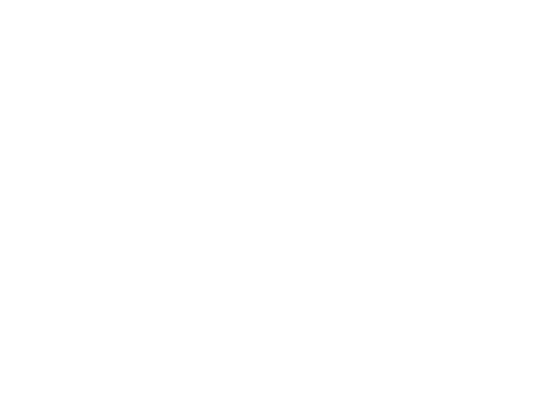

In [51]:
% Plots the percent changes in Ktrans, ve, vp for RRIFT and ETM on
% downsampled in-vivo data.

% Estimated runtime: 2 seconds

clearvars
fclose('all')
addpath('./RRIFT/mfiles')

inDir = './RRIFT/data/TCGA-GBM-Results/c06_downsampled';


matFiles = dir([inDir '/*.mat']);

pkCEs = [];
pkETs = [];
estKepRR = [];
estKtRR = [];

for q=1:length(matFiles)
    curFile = matFiles(q).name;
    load(fullfile(inDir,curFile));
    %%
    pkCEs = [pkCEs; pkCE];
    pkETs = [pkETs; pkETM];
    estKepRR = [estKepRR; estKepRRs];
    estKtRR = [estKtRR; estKtRRs];
end
%%
errKtCE = PercentError(squeeze(pkCEs(:,1,:)),pkCEs(:,1,1));
errVeCE = PercentError(squeeze(pkCEs(:,2,:)),pkCEs(:,2,1));
errKepCE = PercentError(squeeze(pkCEs(:,3,:)),pkCEs(:,3,1));
errVpCE = PercentError(squeeze(pkCEs(:,4,:)),pkCEs(:,4,1));

estVe = squeeze(pkETs(:,1,:)./pkETs(:,2,:));

errKtET = PercentError(squeeze(pkETs(:,1,:)),pkETs(:,1,1));
errVeET = PercentError(estVe(:,:),estVe(:,1));
errKepET = PercentError(squeeze(pkETs(:,2,:)),pkETs(:,2,1));
errVpET = PercentError(squeeze(pkETs(:,3,:)),pkETs(:,3,1));
%%
cSize = 10;

% Err Kt
figure('Position',[300,300,1500,400]); 

curErr = errKtCE;
errQt1 = quantile(curErr,[.25 .75]);
errMd1 = nanmedian(curErr);

curErr = errKtET;
errQt2 = quantile(curErr,[.25 .75]);
errMd2 = nanmedian(curErr);


% Err Ve
curErr = errVeCE;
errQt3 = quantile(curErr,[.25 .75]);
errMd3 = nanmedian(curErr);

curErr = errVeET;
errQt4 = quantile(curErr,[.25 .75]);
errMd4 = nanmedian(curErr);


% Err Vp
curErr = errVpCE;
errQt5 = quantile(curErr,[.25 .75]);
errMd5 = nanmedian(curErr);

curErr = errVpET;
errQt6 = quantile(curErr,[.25 .75]);
errMd6 = nanmedian(curErr);


In [50]:
%get TRes --from MATLAB

%get errQt1 --from MATLAB
%get errMd1 --from MATLAB

%get errQt2 --from MATLAB
%get errMd2 --from MATLAB

%get errQt3 --from MATLAB
%get errMd3 --from MATLAB

%get errQt4 --from MATLAB
%get errMd4 --from MATLAB

%get errQt5 --from MATLAB
%get errMd5 --from MATLAB

%get errQt6 --from MATLAB
%get errMd6 --from MATLAB

fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=(r'$K^{trans}$', r'$V_e$', r'$V_p$'))


line_colours = ['#585e9a', '#f36a61']
line_names = ['RRIFT', 'ETM']


# First subplot

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt1[0,:]-errMd1), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt1[1,:]-errMd1), 10)))

fig.append_trace(go.Scatter(
        name=line_names[0],
        x=TRes,
        y=errMd1,
        showlegend=False,
        legendgroup=1,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[0],
    ),row=1, col=1)

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt2[0,:]-errMd2), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt2[1,:]-errMd2), 10)))

fig.append_trace(go.Scatter(
        name=line_names[1],
        x=TRes,
        y=errMd2,
        showlegend=False,
        legendgroup=2,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[1],
    ),row=1, col=1)



# Second subplot 

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt3[0,:]-errMd3), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt3[1,:]-errMd3), 10)))

fig.append_trace(go.Scatter(
        name=line_names[0],
        x=TRes,
        y=errMd3,
        showlegend=True,
        legendgroup=1,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[0],
    ),row=1, col=2)

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt4[0,:]-errMd4), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt4[1,:]-errMd4), 10)))

fig.append_trace(go.Scatter(
        name=line_names[1],
        x=TRes,
        y=errMd4,
        showlegend=True,
        legendgroup=2,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[1],
    ),row=1, col=2)

# Third subplot

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt5[0,:]-errMd5), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt5[1,:]-errMd5), 10)))

fig.append_trace(go.Scatter(
        name=line_names[0],
        x=TRes,
        y=errMd5,
        showlegend=False,
        legendgroup=1,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[0],
    ),row=1, col=3)

err_negative = np.squeeze(np.asarray(np.reshape(abs(errQt6[0,:]-errMd6), 10)))
err_positive = np.squeeze(np.asarray(np.reshape(abs(errQt6[1,:]-errMd6), 10)))

fig.append_trace(go.Scatter(
        name=line_names[1],
        x=TRes,
        y=errMd6,
        showlegend=False,
        legendgroup=2,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=err_positive,
            arrayminus=err_negative,
            symmetric=False,
            thickness=4, width=9),
        line_color=line_colours[1]
    ),row=1, col=3)


fig.add_hline(y=0, line_dash="dot", line_color="black", line_width=1.69, col="all")

fig.update_xaxes(title_text=r'$Temporal\: Resolutions\: [s]$',
                 range=[0,50], 
                 tickvals=[0, 10, 20, 30, 40, 50],
                 row=1, col=1)
fig.update_xaxes(title_text=r'$Temporal\: Resolutions\: [s]$',
                 range=[0, 50], 
                 tickvals=[0, 10, 20, 30, 40, 50],
                 row=1, col=2)
fig.update_xaxes(title_text=r'$Temporal\: Resolutions\: [s]$',
                 range=[0, 50], 
                 tickvals=[0, 10, 20, 30, 40, 50],
                 row=1, col=3)


fig.update_yaxes(title_text=r'$Percent\: Change$',
                 range=[-100, 100], 
                 tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100],
                 row=1, col=1)
fig.update_yaxes(title_text=r'$Percent\: Change$',
                 range=[-100, 100], 
                 tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100],
                 row=1, col=2)
fig.update_yaxes(title_text=r'$Percent\: Change$',
                 range=[-100, 100], 
                 tickvals=[-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100],
                 row=1, col=3)



    


    
fig.show()
